In [1]:
import numpy as np
from STMiner.SPFinder import SPFinder

E:\conda\envs\dev\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
E:\conda\envs\dev\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
E:\conda\envs\dev\Lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument was not s

In [2]:
sp = SPFinder()
# sp.read_h5ad(file='I://zebrafish/10X_Visium_hunter2021spatially_sample_C_data.h5ad')
sp.read_h5ad(file='I://Adult.h5ad', bin_size=20)

In [9]:
import pandas as pd
df = pd.DataFrame(sp.adata.X.todense())
df.index = sp.adata.obs['x'].astype(str)+'x'+sp.adata.obs['y'].astype(str)
df.columns = sp.adata.var.index
df.T.to_csv('count.csv')

In [ ]:
sp.flush_app()
sp.app.run()

In [8]:
import pandas as pd
spark = pd.read_csv('I://dre_spark_result.csv')

In [10]:
sorted = spark.sort_values(by='combined_pvalue')

In [22]:
genes = list(sorted.loc[:,'Unnamed: 0'][:2630].values)

In [ ]:
sp.load_marked_image('')

In [53]:
sp.fit_pattern(n_comp=20, min_cells=200, n_top_genes=1000)

Fitting GMM...: 100%|██████████| 1000/1000 [02:31<00:00,  6.62it/s]


In [54]:
sp.build_distance_array()

Building distance array...: 100%|██████████| 1000/1000 [18:42<00:00,  1.12s/it]


In [91]:
import pandas as pd

df = pd.DataFrame(sp.genes_distance_array.mean(axis=1), columns=['mean'])
df = df.sort_values(by='mean')
hv_gene_list = list(df[:500].index)
new_array = sp.genes_distance_array.loc[hv_gene_list, hv_gene_list]

,RPS3[hs] | AMEX60DDU001001251,RPL13 | AMEX60DD017083,RPL32 | AMEX60DD023508,RPS6 | AMEX60DD043373,DBI | AMEX60DD056035,DR999_PMT12225[nr]|PPDPF[hs] | AMEX60DD027003,PHYPO_G00119530[nr]|RPS28[hs] | AMEX60DD014694,FTH1[hs] | AMEX60DD016343,LOC506251[nr]|RPL8[hs] | AMEX60DD036991,RPL39 | AMEX60DD037237,...,PPP1R32 | AMEX60DD004614,GRM3 | AMEX60DD006244,ANXA11 | AMEX60DD052235,TARS3 | AMEX60DD014720,PLD2 | AMEX60DD012651,AMEX60DD045376,PTN[nr] | AMEX60DD007022,PCDH18 | AMEX60DD044712,FOXRED1 | AMEX60DD053631,MCC | AMEX60DD042762
RPS3[hs] | AMEX60DDU001001251,0.000000,0.366322,0.460089,0.580647,0.598913,0.554910,0.357596,0.649695,0.587540,0.538163,...,1.153022,1.162473,1.113763,1.184055,1.113729,1.213551,1.111338,1.117931,1.136494,1.178367
RPL13 | AMEX60DD017083,0.366322,0.000000,0.419353,0.459807,0.631336,0.526504,0.361226,0.672753,0.526667,0.467707,...,1.227439,1.234383,1.107765,1.171051,1.179274,1.217197,1.029773,1.073130,1.152424,1.194833
RPL32 | AMEX60DD023508,0.460089,0.419353,0.000000,0.630941,0.748856,0.669755,0.574424,0.693850,0.600807,0.428499,...,1.213502,1.225869,1.104301,1.111109,1.161807,1.154415,1.145564,1.049409,1.201723,1.146241
RPS6 | AMEX60DD043373,0.580647,0.459807,0.630941,0.000000,0.620844,0.598360,0.472170,0.567887,0.593029,0.536597,...,1.183020,1.222950,1.099023,1.193692,1.208252,1.192711,1.149532,1.130636,1.150757,1.127002
DBI | AMEX60DD056035,0.598913,0.631336,0.748856,0.620844,0.000000,0.660284,0.590186,0.613004,0.579308,0.703463,...,1.073561,1.151654,1.194117,1.207475,1.132871,1.169046,1.032301,1.103195,1.108268,1.115371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AMEX60DD045376,1.213551,1.217197,1.154415,1.192711,1.169046,1.161686,1.199187,1.161006,1.215744,1.196697,...,1.241636,1.264884,1.433045,1.120720,1.396979,0.000000,1.400902,1.297086,1.266493,1.292709
PTN[nr] | AMEX60DD007022,1.111338,1.029773,1.145564,1.149532,1.032301,1.151957,1.108306,1.113415,1.114929,1.180184,...,1.418326,1.234081,1.369060,1.410365,1.066092,1.400902,0.000000,1.337829,1.321903,1.354116
PCDH18 | AMEX60DD044712,1.117931,1.073130,1.049409,1.130636,1.103195,1.183467,1.190059,1.109011,1.124007,1.120610,...,1.329957,1.399610,1.371637,1.278345,1.419489,1.297086,1.337829,0.000000,1.284550,1.302819
FOXRED1 | AMEX60DD053631,1.136494,1.152424,1.201723,1.150757,1.108268,1.142472,1.200004,1.227611,1.156714,1.219448,...,1.238152,1.306732,1.384179,1.210174,1.443350,1.266493,1.321903,1.284550,0.000000,1.292922


In [30]:
sp.plot.plot_cluster_score(mds_comp=20,min_cluster=5,max_cluster=10)

TypeError: SPFinder.cluster_gene() got multiple values for argument 'mds_components'

In [50]:
sp.cluster_gene(n_clusters=6, mds_components=20)

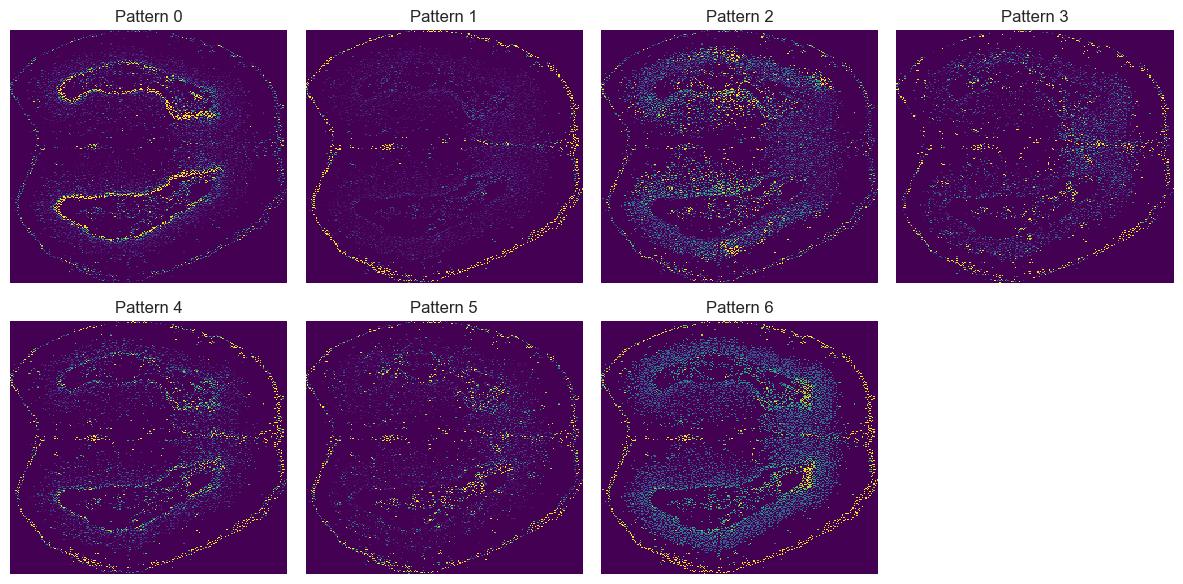

In [49]:
sp.plot.plot_pattern(vmax=99)

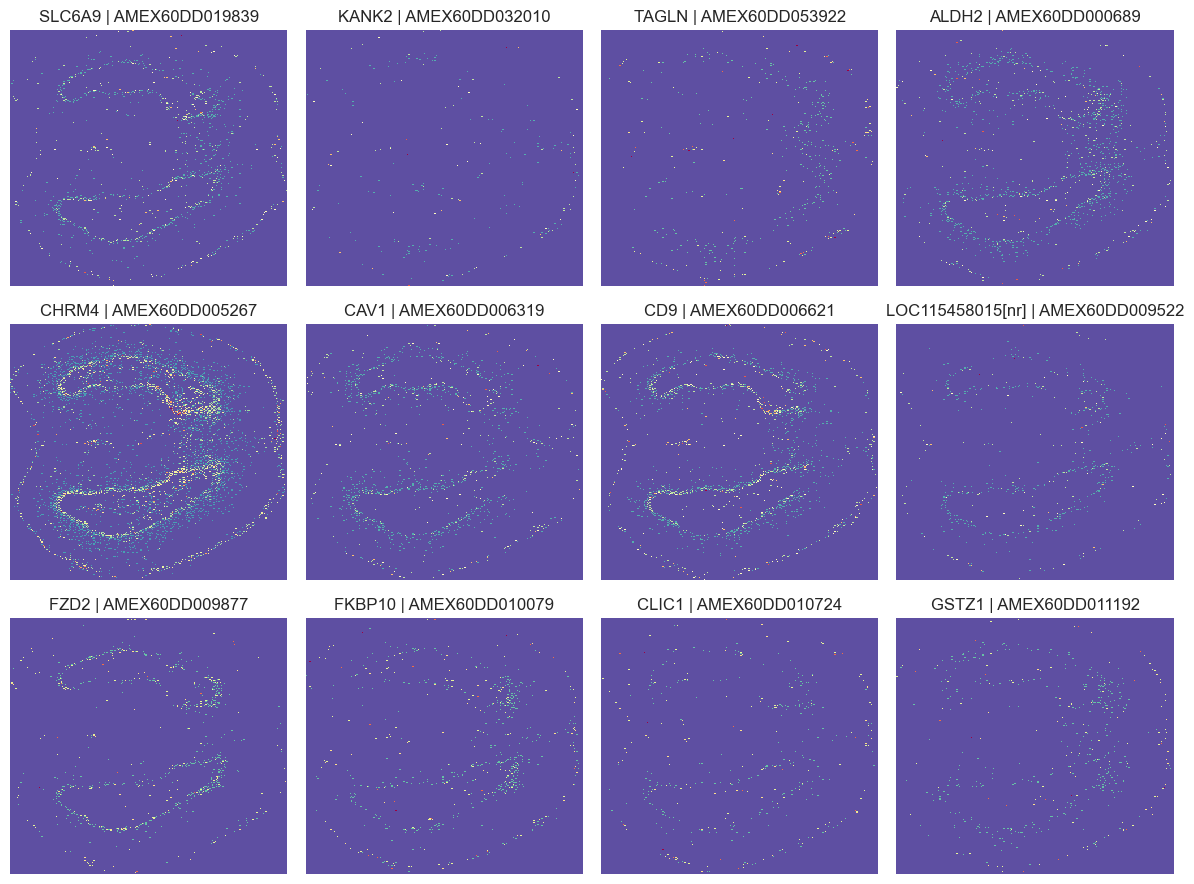

In [41]:
sp.plot.plot_genes(label=2, vmax=100)

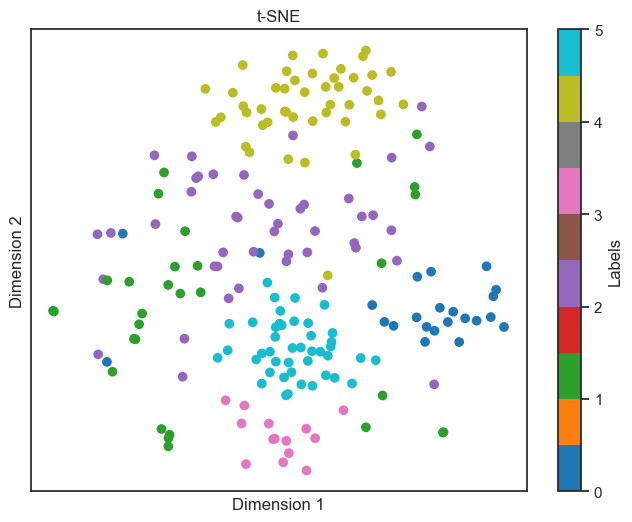

In [51]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embedded_data = tsne.fit_transform(sp.mds_features)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=sp.kmeans_fit_result.labels_, cmap='tab10')
plt.title("t-SNE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(scatter, label='Labels')
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

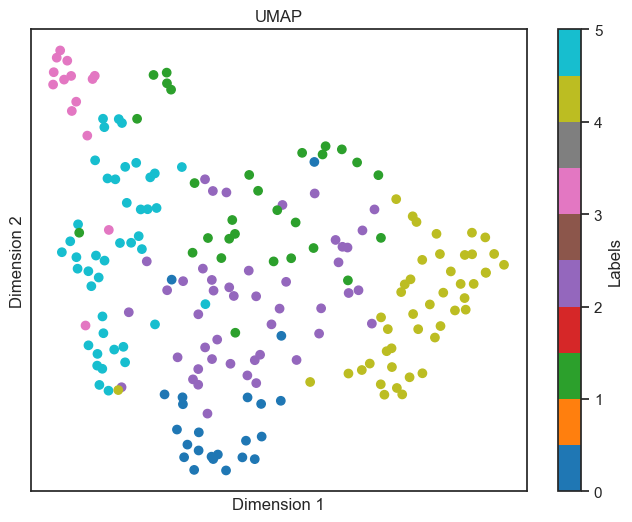

In [52]:
import umap
import matplotlib.pyplot as plt
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2)
embedded_data = umap_model.fit_transform(sp.mds_features)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=sp.kmeans_fit_result.labels_,cmap='tab10')
plt.title("UMAP")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(scatter, label='Labels')
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
df = sp.compare_gene_to_genes('BRAFhuman')

In [8]:
x_min = sp.adata.obsm['spatial_real'][:,1].min()
x_max = sp.adata.obsm['spatial_real'][:,1].max()
y_min = sp.adata.obsm['spatial_real'][:,0].min()
y_max = sp.adata.obsm['spatial_real'][:,0].max()
print(x_min, x_max, y_min,y_max)

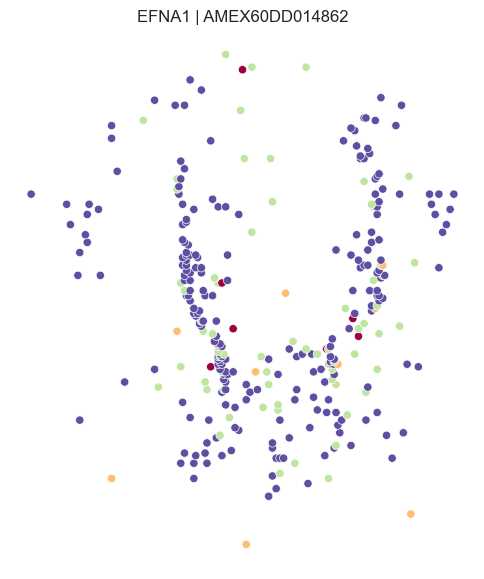

In [65]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 7))
sp.plot.plot_gene('EFNA1 | AMEX60DD014862', reverse_x=True, rotate=True)

In [ ]:
def get_gmm(matrix, n_comp=10):
    arr = np.array(matrix, dtype=np.int32)
    result = array_to_list(arr)
    gmm = mixture.GaussianMixture(n_components=n_comp, max_iter=200).fit(result)
    return gmm


image = io.imread("E:/data/RegionC/RegionCplaqueHires.png")
cropped_image = cut_image(image)
resized = transform.resize(cropped_image, get_exp_array(adata, adata.var.index[0]).shape)
gaussian = filters.gaussian(resized, 3)
binary = np.where(gaussian > np.percentile(gaussian, 40), 1, 0)
gmm = get_gmm(binary, n_comp=20)

In [ ]:
x_min = sp.adata.obsm['spatial_real'][:,1].min()
x_max = sp.adata.obsm['spatial_real'][:,1].max()
y_min = sp.adata.obsm['spatial_real'][:,0].min()
y_max = sp.adata.obsm['spatial_real'][:,0].max()
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
# 打开图像文件
image = Image.open("E://human/GSM4838132_Visium_B_image.tif/GSM4838132_Visium_B_image.tif")  # 替换为你的图像文件路径

# 使用crop方法进行剪裁
cropped_image = image.crop((x_min, y_min, x_max, y_max))

# 保存剪裁后的图像
cropped_image.save("cropped_image.tif")  # 保存为新的文件，也可以覆盖原始文件

In [ ]:
sp.fit_pattern(n_top_genes=500, n_comp=50, min_cells=200)
sp.build_distance_array()

In [ ]:
sp.adata.var

In [ ]:
sp.cluster_gene(n_clusters=7, mds_components=20)

In [ ]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import silhouette_score

db = {}
ch = {}
si = {}
for i in range(2, 12):
    sp.cluster_gene(n_clusters=i, mds_components=20)
    db[i] = 1 / davies_bouldin_score(sp.genes_distance_array, sp.kmeans_fit_result.labels_)
    ch[i] = calinski_harabasz_score(sp.genes_distance_array, sp.kmeans_fit_result.labels_)
    si[i] = silhouette_score(sp.genes_distance_array, sp.kmeans_fit_result.labels_)


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
index = pd.DataFrame([db,si,ch], index=['1/db','si','ch']).T
index_1 = (index-index.min()) / (index.max() - index.min())
sns.lineplot(index_1, markers=True)
plt.xticks(list(range(2, 12, 1)))
plt.xlabel("Number of Clusters")
plt.ylabel("Normalized Score")
plt.title("Evaluate Clustering Performance")
plt.show()

In [ ]:
sp.plot.plot_pattern(vmax=99, rotate=True, reverse_y=True, reverse_x=True)

In [ ]:
sp.plot.plot_genes(label=2, vmax=99, n_gene=20, cmap='viridis', plot_type='heatmap', rotate=True, reverse_y=True,
                   reverse_x=True)

In [ ]:
import matplotlib.pyplot as plt

li = ['pknox1.2','si:dkey-238c7.12','snrpd1','mitfa','rps12','eef2b','ppt1','sumo3b','slc7a3a','zgc:152791','eef1db','si:dkeyp-1h4.9','frzb','rps29','emp3b','tacc1','dusp6','lamb1b','tfap2e','rps7','rps27.1','sept7a','pleca','nme2b.1','spns1','aldh7a1','eif3i','pgm2','cxxc5a','si:ch73-1a9.3','tuba8l3','rpl5b','hdac1','palm1b','si:ch73-46j18.5','mt2','ldb1a','naca','rpl36a','fam120c','hnrnpa1b','sh3bgrl3','h2afvb','rpl31','si:dkey-188i13.7','myo1b','NUPR2','snrpb','ppiaa','rpl21','runx3','eif3s10','KRT18 (1 of many)','hspa8','zgc:123068','bzw1a','arl6ip1','hmgb1a','rplp1','eno1a','top2b','slc20a1b','ap2m1a','rpl14','cirbpa','tfr1b','rpl7a','nudcd3','flnbl','dlx2a','prdx2','sf3b5','si:dkey-238c7.13','ppiab','mycn','abl2','tfap2c','histh1l','rps10','isg15','svila','si:dkey-226k3.4','hnrpdl','csnk2b','alcama','paics','gpr143','NACC1 (1 of many)','si:dkey-188i13.9','srsf5a','hsp90ab1','zgc:153317','hmgb2b','denr','si:ch211-288g17.3','sypl2b','tbx2a','rtn1b','reep5','si:ch73-281n10.2','rpl11','NAPSA','uap1l1','marcksl1b','slc39a10','slc3a2b','cds2','psmb1','hnrnpr','rbm4.3','ddx21','psap','tubb2b','rpl29','march5l','map3k1','st8sia6','zgc:101846','si:ch211-156j16.1','pcna','ywhaz','anxa5b','rps16','EGFP','COX5B (1 of many)-1','hp1bp3','tuba8l4','ncl','sox10','sept9a','fkbp4','cnbpa','sfpq','trpm1b','col9a2','eif3f','colec12','snrpg','jam3b','rps24','rps18','chtopa','hnrnpl2','fkbp1aa','si:dkey-188i13.6','bri3','ctsla','eif3ha','cct5','sub1a','stat2','h1fx','rpl8','actr1','rpl6','rimkla','pbdc1','gpx4b','si:ch211-232b12.5','tln1','hmgn7','CU639413.1','sap18','lnpa','2-Sep','syncrip','CABZ01075268.2','qkia','sf3b1','psmb2','prnpb','cndp2','cart3','rps15','rnf2','cox4i2','seh1l','hmgb2a','h3f3a','zgc:162944','dynll1','rpl23','serinc1','anp32e','si:dkeyp-1h4.8','snx5','rps13','mhc1zba','rps23','rhoac','fam83d','faua','cct8','tmed2','pax3a','rpl23a','rpl10','prdx6','calm3b','CU984600.2','per1a']
for i in li:
    plt.figure(figsize=(6, 7))
    p = sp.plot.plot_gene(i, reverse_x=True, rotate=True,save_path='I:/braf')

In [19]:
import scanpy as sc

adata = sc.read_h5ad('I://human/10X_Visium_hunter2021spatially_sample_C_data.h5ad')

In [52]:
import pandas as pd
li=['frzb','BRAFhuman','myo1b','EGFP','stat1b','dlx2a','ciarta','si:dkey-226k3.4','zgc:152791','rpl31','spon2a','PLA2G10','sub1a','ppiaa','pknox1.2','si:ch211-214p13.9','sypl2b','ppdpfb','wu:fj29h11','runx3','pum3','tpx2','rps12','mt2','rps7','slc7a3a','si:dkey-188i13.6','CABZ01073795.1','eif3s6ip','trpm1b','seph','paics','zgc:162944','sox10','hnrnpr','dgcr2','tfap2e','mitfa','arpc5b','stard13a','eno1a','palm1b','spns1','si:dkey-21a6.5','slc39a10','alcama','scrn3','si:ch73-1a9.3','tfap2c','znfx1','cox4i2','ankrd44','si:ch211-156j16.1','rpl39','lypla2','actr1','rps6','ier5l','zgc:123068','tspan36','zgc:162612','tmsb4x','prdx6','mov10b.1','dynll1','rps24','map3k1','psma3','col9a2','psmb1','gltscr2','pleca','rps26l','mov10a','KRT18 (1 of many)','setd8a','si:dkeyp-1h4.9','pikfyve','drg1','npm1a','ddx39ab','fabp3','cct8','uap1l1','hmga1a','igfbp5b','tubb2b','zgc:153867','sumo3a','mthfd1b','rps8a','snai1a','HELZ2 (1 of many)','il1b','grn1','uba52','si:dkey-238c7.12','commd5','h2afvb','fubp1','u2af1','ivns1abpa','nme2b.1','rps15a','dmtn','syf2','zgc:101846','rpl7a','snrpd2','NUPR2','cnbpa','tcirg1a','ilk','pcna','psmc6','CU984600.2','psmd3','lama4','si:dkey-188i13.9','si:ch211-24o10.6','hmgn2','h3f3a','si:ch211-13c6.2','mxe','sumo3b','fscn1a','tuba8l3','si:dkey-238c7.13','cart3','ecrg4a','rspry1','tcp1','si:dkey-10f21.16','rpl10','nars','marcksl1b','gng2','ppiab','pax3a','h1f0','si:ch211-276k2.1','hint1','anp32b','mhc1zba','flnbl','cdh1','psmb2','mbnl2','pkma','eif3i','COX5B (1 of many)-1','marcksl1a','mki67','akap8l','rpl15','ptges3b','si:dkey-253d23.3','zgc:153317','bace2','rpl23','si:ch73-21k16.6','etf1b','pld1a','si:dkey-26c10.5','crabp2b','plod1a','fkbp1aa','crip2','tacc1','ebna1bp2','slc20a1b','arl6ip1','snu13b','ccdc80','rps18','anxa3b','kifc1','wasf3b','HNRNPUL1 (1 of many)','syncrip','med14','rimkla','snrpd3','ncl','dscr3','ptbp1a','acvrl1','nutf2l','pttg1ipb','stx12','urah','srsf5a','tbx15','hspa8','si:ch211-117c9.5','tp53inp2','rps21','hmgb2a','pmela','polr2k','hnrpdl','sox4a-1','per1a','sh3kbp1','nop58','ostf1','lamb1b','mlpha','tmem163a','naa20','jam3b','tmed2','pdia3','vps72','emp3b','cox6a1','anxa5b','rpl8','cops8','mob4','rpl37-1','magoh','rhocb','exosc8','rac1a','qkia','cep170aa','hmgb2b','si:dkeyp-1h4.8','mfge8b','ppat','rpl18','phf11','ubap2a','sf3b5','rplp1','nme3','p4hb','gstm.1','stard7','RPL41','fnbp1l','vps16','frmd8','il6st','si:dkey-188i13.7','dusp6','rbms2b','tbx2a','wdr3','si:ch1073-392o20.2','si:ch211-197l9.2','fam107b','cxxc5a','cotl1','srsf1a','tln1','nolc1','si:dkey-239h2.3','eif2s1b','reep5','si:dkey-23k10.5','htra1a','ranbp1','arpc3','ap2m1a','dock8','hsp90aa1.2','dync1i2a','sept9a','zfyve21','ube2l3a','pcbd1','cited1','flot2a','mrps25','dars','si:ch211-11c15.3','actb1','crestin','rpl35a','acvr1ba','hps4','cct4','fam168b','PLEKHH3','rps14','wu:fb55g09','spcs1','si:rp71-45k5.4','prmt1','snrpd1','nasp','cdca8','spns3','tktb','erap1b','psmg2','prpf6','tacc3','trappc13','ube2e3','prnpb','si:ch73-46j18.5','isg15','tuba8l4','gmfb','degs1','si:dkey-204f11.64','pno1','mcm3ap','efemp2a','prdx1','anp32e','pdcd4a','ywhabl','cirbpb','rpl28','zgc:111986','cyfip1','nf1b','rabgef1','srsf9','cox17','hmgb1a','ppt1','pora','ubc','aldh9a1a.1','psma1','psmb6','kiaa0101','NAPSA','BICD2 (1 of many)','arrdc3b','rps10','itga5','tfr1b','pard6gb','golga7','gtf2a1','mon1ba','ywhaba','ahcy','mycbp','ywhaz','shfm1','cnih1','gcn1','gucy2c','cndp2','rab1ab','mycn','ppp2cb','st8sia6','rps29','snrpb','cwc22','rpl18a','cltca','serpinh1a','snai2','rpl17','cirbpa','ldb1a','calm3b','parvab','cct3','gpm6ab','aim1a','sap130a','rpf2','rhoac','sdc4','pfdn1','anxa4','lfng','pabpn1','mknk2b','hist2h2l','mgst3b','ncapd2','dap','tubb4b','ftr36','si:dkey-150k17.2','sgsm3','si:dkey-67c22.2','sash1a','nudt21','caprin1b','cstf3','nifk','slc45a2','EIF1B','eif3ha','arhgef1b','pah','noc2l','zgc:153372','msto1','btg3','palm2-1','gadd45bb','svila','c19h1orf109','gskip','rps27.1','hdac1','map4k4','map4k5','sestd1','id2a','rpl5b','pinx1','eif5a2','ube2l3b','cmtm6','apc','pargl','rfc3','rhbdf1a','rtn1b','si:ch211-288g17.3','med13a','emilin1a','mgea5','rer1','seh1l','mibp2','mthfd2','si:ch211-232b12.5','pgam1a','bud31','h1fx','icn','nckap1','mao','anxa13','rnaset2','copa','si:ch211-14a11.5','hsp90ab1','zcchc9','dcbld1','ctnnb1','gdap2','eef2k','ablim3','nat10','polr2f','fbl','ccdc85b','chtopa','bri3','kctd10','rif1','gnb1b','racgap1','rpl6','srsf6a','rpl19','rps25','ak4','cobll1b','eif2s2','efhd2','crebzf','si:ch211-233a24.2','mtmr6','aimp2','cbfb','nucks1b','ccnd1','thoc2','rps27a','huwe1','u2af2b','colec12','capn2a','papolg','zgc:91910','med10','h3f3b.1','mmp14b','hnrnpa1b','zgc:63863','eef1db','ctdsp2','nudcd3','hnrnpm','CU639413.1','hspd1','RPS17','hagh','ilf3b','ssr2','stip1','sox5','RPS27L']
df = pd.DataFrame(adata.var,index=li)

In [36]:
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=2000)

In [52]:
from random import random

li = []
for i in range(10):
    li.append(random())
li

[0.1538274354705882,
 0.9200467285870609,
 0.4848178281364194,
 0.87739784782596,
 0.5321751289523085,
 0.3518051358923433,
 0.37020133666487454,
 0.6261420731158387,
 0.6365027206481393,
 0.8502904770529097]